# Running Haro 11 through the LARS-mill

This is a description with embedded code of what it takes to run a single COS galaxy spectrum through my LARS-machinery so far.

### Imports

In [1]:
import matplotlib as mpl
import numpy as np
#mpl.use('Qt5Agg')
import pickle
import cospaper as cosp
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import mpl_tricks as mp
from astropy.io import fits
import astropy.constants as co
from astropy.units import Quantity
import astropy.units as u

/home/trive/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
coldict = {'Si_II_1304':cosp.paircolors[1], 
           'Si_II_1526':cosp.paircolors[3],
           'Si_II_1260':cosp.paircolors[9],
           'O_I_1302': 'k',
           'C_II_1334': 'gray',
           'Si_IV_1393':cosp.paircolors[5],
           'Si_IV_1402':cosp.paircolors[7]
          }

### Data preparation

First, run read the data into a NumPy array. 

In [3]:
data = sp.genfromtxt('../Data/haro11_stack.coarse.ascii')

Now, read the numpy array into a Pandas `DataFrame()` object.
Set appropriate column names, set the wavelength column as the index (but keep them as an ordinary column as well), set the galaxy name as headline for columns.

In [4]:
# Basically does what cosp.load_spectrum() does.
thedata = pd.DataFrame(data)
thedata.columns = ['wave', 'flam', 'stddev', 'flag']
thedata = thedata.set_index('wave', drop=False)
thedata.columns.name = 'Haro11C'

Now, remove all rows that have flags different from zero.

*NB! Is this too strict a regime?*

In [5]:
thedata['flag'].iloc[sp.where(thedata.flag > 0)] = sp.nan
thedata.dropna().head()

Haro11C,wave,flam,stddev,flag
wave,,,,
1151.886559,1151.886559,2.850328e-15,6.729086e-15,0.0
1151.898794,1151.898794,3.812098e-15,5.175205e-15,0.0
1151.911030,1151.911030,7.259020e-15,5.763337e-15,0.0
1151.923266,1151.923266,1.070719e-14,6.953590e-15,0.0
1151.935502,1151.935502,9.850106e-15,7.055407e-15,0.0


Now, calculate a systemic redshift from what Andreas has measured:

In [6]:
velHa = Quantity(6126000., unit=u.m/u.s)
from helper_functions import deltawl_to_v
z = velHa / co.c
deltaz = 7000. * u.m/u.s / co.c 
z, deltaz 

(<Quantity 0.020434136471838796>, <Quantity 2.3349486663870643e-05>)

$0.020434 \pm 0.00002335$

Now, rebin data. Put a band-aid on any remaining near-zero-error problems. Set the redshift as an attribute and painfully re-set it every time an non-inplace operation is performed on the DataFrame (yes, I wrote this before I learned about proper subclassing). 

Finally, create a smoothed version of the date (mostly for visualization not for computations).

## Computations

First, in order to meet the expectations of the code, wrap the spectrum into a dict (even if it has only one member). When I grow up, Imma write a procedure that takes care of this, but that is not for now.

Next, normalize all involved lines, and set proper masks.

Next, make Wofford-style line profile plots. Just for the heck of it. Also here is room for improvement, but that's for later. 

***This is not reproducible, so once a satisfactory result is reached, this should be ~~pickled~~ saved in human readable form and these steps should not be run again.*** 

In [7]:
Quantity(1526., unit=u.Angstrom) * (1 + z)

<Quantity 1557.182492256026 Angstrom>

In [8]:
#reload(cosp)
#thedict = {1: thedata} 
#thedict = cosp.make_line_profile_plots(indict=thedict, lines='hilo')
#plt.show()

In [9]:
#cosp.pickle_df(thedict, filename='./Haro11/dfdict.pickle')

### LIS lines / Si II lines
Now, compute covering fractions for the low-ionization lines.

In [10]:
import pandas as pd
thedict = pd.read_pickle('../Products/dfdict.pickle')
vfhis = pd.read_pickle('../Products/vfhis.pickle')
vflis = pd.read_pickle('../Products/vflis.pickle')
vfhisHaro = vfhis.copy()
vflisHaro = vflis.copy()

In [12]:
vflis[1].columns

Index([u'Velocity', u'Si_II_1304_Flam', u'Si_II_1304_Stddev',
       u'Si_II_1304_Mask', u'Si_II_1526_Flam', u'Si_II_1526_Stddev',
       u'Si_II_1526_Mask', u'Si_II_1260_Flam', u'Si_II_1260_Stddev',
       u'Si_II_1260_Mask', u'Si_II_CovFrac_map', u'Si_II_CovFrac_err',
       u'Si_II_CovFrac_lo_err', u'Si_II_ColDens_map', u'Si_II_ColDens_err',
       u'Si_II_ColDens_lo_err', u'Si_II_CovFrac_Xsq', u'Si_II_NumLines',
       u'O_I_1302_Flam', u'O_I_1302_Stddev', u'O_I_1302_Mask',
       u'C_II_1334_Flam', u'C_II_1334_Stddev', u'C_II_1334_Mask',
       u'MeanProfile', u'MeanErrors'],
      dtype='object', name=u'Haro11C')

In [13]:
%pylab qt4

Populating the interactive namespace from numpy and matplotlib


In [14]:
vh = vfhis[1].copy()
vl = vflis[1].copy()
vl.index += 36
vv = vl.join(vh, lsuffix='LIS', rsuffix='HIS', how='left')
#vv.plot.scatter('Si_IV_CovFrac_map', 'Si_II_CovFrac_map', color='orange')
#vv.plot.scatter('MeanProfileLIS', 'MeanProfileHIS', color='orange', ax=gca())
#plot(linspace(0, 1, 100), 0.6*linspace(0, 1, 100)-.05)

In [19]:
plot(vh.Velocity, vh.Si_IV_1393_Flam)
#plot(vh.Velocity, vh.Si_IV_1402_Flam)
axhline(1, color='k')

In [13]:
vh.head()

Haro11C,Velocity,Si_IV_1393_Flam,Si_IV_1393_Stddev,Si_IV_1393_Mask,Si_IV_1402_Flam,Si_IV_1402_Stddev,Si_IV_1402_Mask,Si_IV_CovFrac_map,Si_IV_CovFrac_err,Si_IV_CovFrac_lo_err,Si_IV_ColDens_map,Si_IV_ColDens_err,Si_IV_ColDens_lo_err,Si_IV_CovFrac_Xsq,Si_IV_NumLines,MeanProfile,MeanErrors
0,-4169.764147,0.912277,0.085395,True,1.156214,0.069565,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.034245,0.110144
1,-4154.289049,0.863517,0.084502,True,1.248966,0.076876,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.056241,0.114239
2,-4138.813951,0.871957,0.086273,True,1.221780,0.077732,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.046869,0.116126
3,-4123.338854,0.772896,0.080649,True,1.092365,0.075893,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.932631,0.110742
4,-4107.863756,0.735109,0.082498,True,1.174422,0.076761,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.954766,0.112686


In [15]:
%pylab qt4
factor = 0.7
kernel = np.ones(1)/1.
SiII = vl.Si_II_1260_Flam
CII = vl.C_II_1334_Flam
SiIIoff = np.roll(SiII.values, 15)
SiIIoff = (SiIIoff - 1.) * factor + 1.
plt.plot(vl.Velocity, np.convolve(CII, kernel, mode='same'), 
         color=coldict['C_II_1334'], label='C II 1334+1335', lw=1.2, drawstyle='steps-mid')
mp.fill_between_steps(vl.Velocity.values, 
                      vl.C_II_1334_Flam.values - vl.C_II_1334_Stddev.values, 
                      vl.C_II_1334_Flam.values + vl.C_II_1334_Stddev.values,
                      color='lightgray', zorder=0, 
                     )
plt.plot(vl.Velocity, np.convolve(SiII, kernel, mode='same'), 
         color=coldict['Si_II_1260'], label='Si II 1260', lw=1.2, drawstyle='steps-mid')
plt.fill_between(vl.Velocity, 
                      vl.Si_II_1260_Flam - vl.Si_II_1260_Stddev, 
                      vl.Si_II_1260_Flam + vl.Si_II_1260_Stddev,
                      color=cosp.paircolors[8], zorder=0, step='mid'
                     )
plt.plot(vl.Velocity, np.convolve(SiII * SiIIoff, np.ones(1)/1., mode='same'), 
         color='k', label='Model C II', lw=2.4, drawstyle='steps-mid' )
#plt.plot(vl.Velocity, np.convolve(CII / SiII, kernel, mode='same'))
#plt.plot(vl.Velocity, np.convolve(SiII, kernel, mode='same'))
plt.axhline(0, color='k', ls='-')
plt.axvline(0, color='k', ls=':')
plt.axhline(1, color='k', ls=':')
plt.axis((-800, 800, -.2, 1.4))
plt.legend(loc='best')
plt.xlabel(u'$v - v_0$ [km s⁻¹]')
plt.ylabel('Normalized flux')
plt.show()


Populating the interactive namespace from numpy and matplotlib


In [16]:
offset = vl.Velocity.values[1:] - vl.Velocity.values[:-1]
offset.mean(), offset.ptp()
print np.around(253. / offset.mean())
print 10 * offset.mean()

15.0
165.635611269


In [26]:
import numpy as np
np.ro

AttributeError: 'module' object has no attribute 'ro'

In [14]:
#reload(cosp)
#thefile = open('./Haro11/dfdict.pickle')
#thedict = pickle.load(thefile)
#thedict[1].z_value = z.value
#vflisHaro = cosp.make_cover_frac_plots(
#    thedict, lines=cosp.SiIIlines, 
#    compare_lines=cosp.lislines, minimizer='brute')
#plt.show()

Generate the $f_c$ / $N_c$ / pseudo-red. $\chi^2$ triple plot:

In [15]:
#reload(cosp)
#%pylab qt4
#cosp.single_coverfrac_plot(
#    vflisHaro[1], dotcolor=cosp.paircolors[3], 
#    barcolor=cosp.paircolors[2])

## Optically thick?

In [17]:
#%matplotlib inline
vlis = vflis[1]
vlis.columns
plt.figure(figsize=(6, 4))
plt.plot(vlis.Velocity, vlis.Si_II_1260_Flam, 'k-', drawstyle='steps-mid')
plt.fill_between(
    vlis.Velocity, 
    vlis.Si_II_1260_Flam+vlis.Si_II_1260_Stddev, 
    y2=vlis.Si_II_1260_Flam - vlis.Si_II_1260_Stddev, 
    color='gray', alpha=.5, step='mid')
plt.plot(vlis.Velocity, 1. - vlis.Si_II_CovFrac_map, 'o', color='orange', mec='orange')
plt.fill_between(
    vlis.Velocity, 
    1 - (vlis.Si_II_CovFrac_map+vlis.Si_II_CovFrac_err), 
    y2=1 - (vlis.Si_II_CovFrac_map - vlis.Si_II_CovFrac_lo_err), 
    color='orange', alpha=.5, step='mid')
plt.tick_params(labelsize=12)
plt.axis((-1000, 600, -.1, 1.4))
plt.axhline(0, color='k', ls='-', lw=.9)
plt.axvline(0, color='k', ls=':', lw=.9)
plt.show()

### Demonstrate AOD

In [18]:
# zero-bin:231
binnum = 231
print vlis.Velocity.loc[binnum], vlis.Si_II_CovFrac_map.loc[binnum], vlis.Si_II_ColDens_map.loc[binnum]
from linelists import fikdict as fd
import numpy as np
fig, axes = plt.subplots(1, 2, figsize=(7, 3.), sharex=False)
plt.sca(axes[1])
SiFiks = [1.22, 0.0928, 0.133]  # 1260, 1304, 1526
SiFikLam = np.array([1.22*1260., 0.0928*1304., 0.133*1526])
FikLams = np.linspace(0, 1700, 100)
taus = FikLams * 10**vlis.Si_II_ColDens_map.loc[binnum] / (3.768e14)
Ifunc = 1 - vlis.Si_II_CovFrac_map.loc[binnum]*(1 - np.exp(-taus)) 

HiTau = FikLams * 10**11.6 / 3.768e14
LoTau = FikLams * 10**13 / 3.768e14
#HiIfunc = 1 - vlis.Si_II_CovFrac_map.loc[binnum]*(1 - np.exp(-HiTau))
HiIfunc = 1 - .999*(1 - np.exp(-HiTau))
LoIfunc = 1 - vlis.Si_II_CovFrac_map.loc[binnum]*(1 - np.exp(-LoTau))
MdIfunc = 1 - .6*(1 - np.exp(-HiTau))

SiFlams = vlis[['Si_II_1260_Flam', 'Si_II_1304_Flam', 'Si_II_1526_Flam']]
SiErrs = vlis[['Si_II_1260_Stddev', 'Si_II_1304_Stddev', 'Si_II_1526_Stddev']]

plt.plot(FikLams, Ifunc, 'm-')
plt.plot(FikLams, HiIfunc, '--', color='gray')
plt.plot(FikLams, LoIfunc, ':', color='gray')
plt.errorbar(SiFikLam, SiFlams.loc[binnum].values, SiErrs.loc[binnum].values, ls='', color='k')
plt.plot(SiFikLam, SiFlams.loc[binnum], 'ko')
#plt.plot(FikLams, MdIfunc, '--', color='gray')
plt.xlabel('$f\lambda$')
plt.ylabel('Relative flux')
plt.xticks([0, 500, 1000, 1500])
#plt.sca(axes[2])
#plt.xlabel('$v-v_0$ [km s$^{-1}$]')
#plt.ylabel('log N')
#plt.xticks([-600, -400, -200, 0, 200, 400])
#plt.plot(vlis.Velocity, vlis.Si_II_ColDens_map, 'k-', drawstyle='steps-mid')
#mp.fill_between_steps(vlis.Velocity.values, 
#                      vlis.Si_II_ColDens_map.values + vlis.Si_II_ColDens_err.values, 
#                      vlis.Si_II_ColDens_map.values - vlis.Si_II_ColDens_lo_err.values, 
#                     color='lightgray',)
#plt.ylim(10, 15)
#plt.axvline(vlis.Velocity.loc[binnum], color='r', ls='-')
#plt.annotate('log N = {}'.format(vlis.Si_II_ColDens_map.loc[binnum]), (0.05, 0.92), xycoords='axes fraction')
#plt.xlim(-500, 300)#

#plt.sca(axes[3])
#plt.xticks([-400, -200, 0, 200])
#plt.xlabel('$v-v_0$ [km s$^{-1}$]')
#plt.ylabel('pseudo-red. $\chi^2$')
#plt.axvline(vlis.Velocity.loc[binnum], color='r', ls='-')
#plt.plot(vlis.Velocity, vlis.Si_II_CovFrac_Xsq, 'k-')
#plt.axis((-500, 300, -1, 40))
plt.sca(axes[0])
vel = vlis.Velocity
plt.plot(vel, SiFlams['Si_II_1260_Flam'], color=coldict['Si_II_1260'], drawstyle='steps-mid')
plt.plot(vel, SiFlams['Si_II_1304_Flam'], color=coldict['Si_II_1304'], drawstyle='steps-mid')
plt.plot(vel, SiFlams['Si_II_1526_Flam'], color=coldict['Si_II_1526'], drawstyle='steps-mid')
plt.axvline(0, color='k', ls=':')
plt.axhline(1, color='k', ls=':')
plt.axvline(vlis.Velocity.loc[binnum], color='r', ls='-')
plt.axis((-500, 300, 0, 1.4))
plt.xlabel('$v-v_0$ [km s$^{-1}$]')
plt.ylabel('Relative flux')
plt.xticks([-400, -200, 0, 200])
plt.subplots_adjust(left=0.05, right=0.97, bottom=.18, wspace=.3)
plt.show()

-6.53212071158 0.46 12.1


### Again, but for applications, not paper

In [20]:
%pylab qt4
# zero-bin:231
binnum = 221
print vlis.Velocity.loc[binnum], vlis.Si_II_CovFrac_map.loc[binnum], vlis.Si_II_ColDens_map.loc[binnum]
from linelists import fikdict as fd
import numpy as np
fig, axes = plt.subplots(1, 4, figsize=(7, 2.5), sharex=False)
plt.sca(axes[1])
plt.axhline(0, color='k', ls='-')
SiFiks = [1.22, 0.0928, 0.133]  # 1260, 1304, 1526
SiFikLam = np.array([1.22*1260., 0.0928*1304., 0.133*1526])
FikLams = np.linspace(0, 1700, 100)
taus = FikLams * 10**vlis.Si_II_ColDens_map.loc[binnum] / (3.768e14)
Ifunc = 1 - vlis.Si_II_CovFrac_map.loc[binnum]*(1 - np.exp(-taus)) 

HiTau = FikLams * 10**11.6 / 3.768e14
LoTau = FikLams * 10**13 / 3.768e14
#HiIfunc = 1 - vlis.Si_II_CovFrac_map.loc[binnum]*(1 - np.exp(-HiTau))
HiIfunc = 1 - .999*(1 - np.exp(-HiTau))
LoIfunc = 1 - vlis.Si_II_CovFrac_map.loc[binnum]*(1 - np.exp(-LoTau))
MdIfunc = 1 - .6*(1 - np.exp(-HiTau))

SiFlams = vlis[['Si_II_1260_Flam', 'Si_II_1304_Flam', 'Si_II_1526_Flam']]
SiErrs = vlis[['Si_II_1260_Stddev', 'Si_II_1304_Stddev', 'Si_II_1526_Stddev']]
plt.axhline(0, color='k', ls='-')
plt.plot(FikLams, Ifunc, 'm-')
plt.plot(FikLams, HiIfunc, '--', color='gray')
plt.plot(FikLams, LoIfunc, ':', color='gray')
plt.errorbar(SiFikLam, SiFlams.loc[binnum].values, SiErrs.loc[binnum].values, ls='', color='k')
plt.plot(SiFikLam, SiFlams.loc[binnum], 'ko')
#plt.plot(FikLams, MdIfunc, '--', color='gray')
plt.xlabel('$f\lambda$')
plt.ylabel('Relative flux')
plt.xticks([0, 500, 1000, 1500])
plt.ylim(-.1, 1.3)
plt.sca(axes[2])
plt.xlabel('$v-v_0$ [km s$^{-1}$]')
plt.ylabel('log N')
plt.xticks([-600, -400, -200, 0, 200, 400])
plt.plot(vlis.Velocity, vlis.Si_II_ColDens_map, 'k-', drawstyle='steps-mid')
mp.fill_between_steps(vlis.Velocity.values, 
                      vlis.Si_II_ColDens_map.values + vlis.Si_II_ColDens_err.values, 
                      vlis.Si_II_ColDens_map.values - vlis.Si_II_ColDens_lo_err.values, 
                     color='lightgray',)
plt.ylim(10, 15)
plt.axvline(vlis.Velocity.loc[binnum], color='r', ls='-')
plt.annotate('log N = {}'.format(vlis.Si_II_ColDens_map.loc[binnum]), (0.05, 0.92), xycoords='axes fraction')
plt.xlim(-500, 300)#

plt.sca(axes[3])
plt.xticks([-400, -200, 0, 200])
plt.xlabel('$v-v_0$ [km s$^{-1}$]')
#plt.ylabel('pseudo-red. $\chi^2$')
plt.axhline(0, color='k', ls='-')
plt.axvline(0, color='k', ls=':')
plt.axhline(1, color='k', ls=':')
plt.axvline(vlis.Velocity.loc[binnum], color='r', ls='-')

mp.fill_between_steps(vlis.Velocity.values, 
                      (vlis.Si_II_1260_Flam.values + vlis.Si_II_1260_Stddev.values), 
                      (vlis.Si_II_1260_Flam.values - vlis.Si_II_1260_Stddev.values), 
                     color='lightgray',)
plt.plot(vlis.Velocity, vlis.Si_II_1260_Flam, 'k-', drawstyle='steps-mid')
mp.fill_between_steps(vlis.Velocity.values, 
                      1-(vlis.Si_II_CovFrac_map.values + vlis.Si_II_CovFrac_err.values), 
                      1 - (vlis.Si_II_CovFrac_map.values - vlis.Si_II_CovFrac_lo_err.values), 
                     color=cosp.paircolors[6], alpha=.6)

plt.plot(vlis.Velocity, 1 - vlis.Si_II_CovFrac_map, 'o', color=cosp.paircolors[7], mew=0)
#plt.axis((-500, 300, -1, 40))
plt.axis((-500, 300, -.1, 1.3))
plt.sca(axes[0])
vel = vlis.Velocity
plt.plot(vel, SiFlams['Si_II_1260_Flam'], color=coldict['Si_II_1260'], drawstyle='steps-mid')
plt.plot(vel, SiFlams['Si_II_1304_Flam'], color=coldict['Si_II_1304'], drawstyle='steps-mid')
plt.plot(vel, SiFlams['Si_II_1526_Flam'], color=coldict['Si_II_1526'], drawstyle='steps-mid')
plt.axhline(0, color='k', ls='-')
plt.axvline(0, color='k', ls=':')
plt.axhline(1, color='k', ls=':')
plt.axvline(vlis.Velocity.loc[binnum], color='r', ls='-')
plt.axis((-500, 300, -.10, 1.3))
plt.xlabel('$v-v_0$ [km s$^{-1}$]')
plt.ylabel('Relative flux')
plt.xticks([-400, -200, 0, 200])
plt.subplots_adjust(left=0.05, right=0.97, bottom=.18, wspace=.3)
plt.show()

Populating the interactive namespace from numpy and matplotlib
-172.167731981 0.576 12.5


In [199]:
from statsmodels.nonparametric import kernel_regression as kr
from statsmodels.nonparametric import smoothers_lowess as lowess
idx = vlis.Si_II_ColDens_map.notnull()
vidx = vlis.Velocity.between(-450, 150)
fidx = idx & vidx
#fidx.ix[218] = False
vels = vlis.Velocity[fidx]
vals = vlis.Si_II_ColDens_map[fidx]
vals[218] = (vals[219]+vals[217]) / 2
reg = kr.KernelReg(vals, vels, 'c',)# bw='')

In [200]:
vals

205    12.04
206    12.28
207    12.08
208    12.62
209    12.02
210    12.28
211    12.26
212    12.38
213    12.36
214    12.44
215    12.36
216    12.54
217    12.54
218    12.65
219    12.76
220    12.70
221    12.50
222    12.40
223    12.50
224    12.60
225    12.38
226    12.34
227    12.34
228    12.38
229    12.46
230    12.28
231    12.10
232    12.18
233    12.06
234    12.14
235    11.86
236    12.04
237    12.56
238    10.44
239    11.24
240    10.00
Name: Si_II_ColDens_map, dtype: float64

In [201]:
result, errs = reg.fit()
#lowout = lowess.lowess(vals, vels, frac=0.25)

In [202]:
Ns = 10 ** result

In [203]:
figure(figsize=(3.5, 3))
plot(vlis.Velocity, 10**vlis.Si_II_ColDens_map, 'k-', drawstyle='steps-mid', label=r'$N_{\rm Si II}$')
plot(vlis.Velocity, 10**vlis.Si_II_ColDens_map, 'k-', drawstyle='steps-mid', label=r'$N_{\rm Si II}$')
plot(vels, Ns, lw=2, color='orange', drawstyle='steps-mid', label=r'$\rm LLE$')
legend(frameon=False)
#plt.fill_between(vels, Ns, color='orange', alpha=.5, step='mid')                 
xlim(-600, 250)
xlabel('$v-v_0$')
ylabel(r'$N_{\rm{Si II}}$')
subplots_adjust(bottom=0.15, left=0.18)
yscale('log')

In [206]:
log10(Ns.sum())

13.872206284357651

In [216]:
#errs = (vlis.Si_II_ColDens_err + vlis.Si_II_ColDens_lo_err) / 2
plot(vlis.Velocity, vlis.Si_II_1260_Stddev, label='1260')
plot(vlis.Velocity, vlis.Si_II_1304_Stddev, label='1304')
plot(vlis.Velocity, vlis.Si_II_1526_Stddev, label='1526')
plot(vlis.Velocity, vlis.MeanErrors, label='combined')
legend()

In [181]:
plt.plot(vlis.Velocity, vlis.Si_II_1260_Flam)
plt.xlim(-1000, 1500)
plt.show()

In [205]:
vels[218]

-221.85841536153151

In [46]:
import lmfit as lf
import profiles as pro

In [55]:
dlis = thedict[1]#.dropna()
dlis = dlis.loc[1275:1295]
flux = dlis.flam
wave = dlis['lambda']
plt.plot(flux, label='Observed data', drawstyle='Steps')
plt.axis((1275, 1295, 0, 3e-13))
plt.axvline(1286.17, color='k', ls=':')
plt.axvline(1290.54, color='k', ls=':')
fl = lf.models.GaussianModel() + lf.models.ConstantModel()
cen = lf.Parameter('center', 1291, min=1289.5, max=1293)
amp = lf.Parameter('amplitude', 2e-14, min=0)
sig = lf.Parameter('sigma', .2, min=.05, max=5)
x = lf.Parameter('c', 1.25e-13, min=1.2e-13)
p = lf.Parameters()
p.add_many(cen, amp, sig, x)
out = fl.fit(dlis.flam, p, x=wave)
#plt.plot(wave, fl.eval(p, x=wave), color='orange')
plt.plot(dlis['lambda'], out.best_fit, color='orange', lw=2, label='SiII* best fit')
aa = 2.58 / 3.06
subt = pro.gauss(dlis['lambda'], 
                 out.best_values['center']-4.3, 
                 out.best_values['sigma'], 
                 out.best_values['amplitude'] * aa)
plt.plot(dlis['lambda'], dlis.flam - subt, color='gray', zorder=1, label='RT-corr. data', 
        drawstyle='Steps', alpha=.5)
plt.legend(loc='best', title='Si II 1260')
plt.xlabel(u'Wave [Å]')
plt.ylabel(u'Flux [erg s⁻¹ cm⁻² Å⁻¹]')
plt.axis((1280, 1293, 0, 2e-13))
plt.show()

In [26]:
fl.eval(p, x=wave).plot()

In [253]:
print(out.fit_report())

[[Model]]
    (Model(gaussian) + Model(constant))
[[Fit Statistics]]
    # function evals   = 83
    # data points      = 273
    # variables        = 4
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -17215.019
    Bayesian info crit = -17200.581
[[Variables]]
    center:      1290.93247 +/- 0        (0.00%) (init= 1290)
    amplitude:   1.9984e-14 +/- 0        (0.00%) (init= 2e-14)
    sigma:       0.33320150 +/- 0        (0.00%) (init= 0.1)
    c:           1.2512e-13 +/- 0        (0.00%) (init= 1.25e-13)
[[Correlations]] (unreported correlations are <  0.100)



In [240]:
out.best_values

{'amplitude': 1.9984014443252818e-14,
 'c': 1.178782364251628e-13,
 'center': 1290.9316639205749,
 'sigma': 0.33130289385833456}

In [ ]:
fl = lf.models.GaussianModel

In [ ]:
fl = lf.models.GaussianModel

### HIS / Si IV lines

Same as above.

In [15]:
thedict[1].z_value = z
vfhisHaro = cosp.make_cover_frac_plots(
    thedict[1], lines=cosp.hislines, 
    compare_lines=cosp.hislines, minimizer='brute')
plt.show()

AttributeError: 'Series' object has no attribute 'z_value'

In [11]:
plt.show()

In [4]:
reload(cosp)
cosp.single_coverfrac_plot(
    vfhisHaro[1], dotcolor=cosp.paircolors[7], 
    barcolor=cosp.paircolors[6], species='Si_IV')

Finally, save the results so far (the below procedures might crash, and we do not want to redo all this if we can avoid it...)

In [68]:
cosp.pickle_df(vflisHaro, filename='Haro11/vflis.pickle')
cosp.pickle_df(vfhisHaro, filename='Haro11/vfhis.pickle')

### Better line profile plots

In [10]:
vflis[1].columns

Index([u'Velocity', u'Si_II_1304_Flam', u'Si_II_1304_Stddev',
       u'Si_II_1304_Mask', u'Si_II_1526_Flam', u'Si_II_1526_Stddev',
       u'Si_II_1526_Mask', u'Si_II_1260_Flam', u'Si_II_1260_Stddev',
       u'Si_II_1260_Mask', u'Si_II_CovFrac_map', u'Si_II_CovFrac_err',
       u'Si_II_CovFrac_lo_err', u'Si_II_ColDens_map', u'Si_II_ColDens_err',
       u'Si_II_ColDens_lo_err', u'Si_II_CovFrac_Xsq', u'Si_II_NumLines',
       u'O_I_1302_Flam', u'O_I_1302_Stddev', u'O_I_1302_Mask',
       u'C_II_1334_Flam', u'C_II_1334_Stddev', u'C_II_1334_Mask',
       u'MeanProfile', u'MeanErrors'],
      dtype='object', name=u'Haro11C')

In [63]:
fig, axs = plt.subplots(2, 1)
dflis = vflis[1]
velis = dflis.Velocity
dfhis = vfhis[1]
vehis = dfhis.Velocity

coldict = {'Si_II_1304':cosp.paircolors[1], 
           'Si_II_1526':cosp.paircolors[3],
           'Si_II_1260':cosp.paircolors[9],
           'O_I_1302': 'k',
           'C_II_1334': 'gray',
           'Si_IV_1393':cosp.paircolors[5],
           'Si_IV_1402':cosp.paircolors[7]
          }

lislines = ['Si_II_1304', 'Si_II_1526', 
            'Si_II_1260','O_I_1302', 'C_II_1334']# 'Si_III_1206']
hislines = ['Si_IV_1393', 'Si_IV_1402']
ax = axs[0]
for line in lislines:
    data = dflis['{}_Flam'.format(line)]
    data = sp.convolve(data, sp.ones(5)/5., mode='same')
    mask = dflis['{}_Mask'.format(line)]
    dm = sp.ma.masked_array(data, mask=sp.invert(mask))
    md = sp.ma.masked_array(data, mask=mask)
    line = ax.plot(velis, dm, drawstyle='steps-mid', label=line.replace('_', ' '), 
                  color=coldict[line])
    ax.plot(velis, md, drawstyle='steps-mid', ls='--', color=line[0].get_color())
ax.axhline(y=1, lw=.8, color='k', ls='--')
ax.axvline(x=0, lw=.8, color='k', ls='--')
ax.axis((-1050, 1050, 0, 1.5))
ax.legend(loc='lower right', frameon=True)
ax.label_outer()
ax.annotate('Haro 11 C', (-1000, 1.3), size='large')
ax.set_ylabel('Relative flux')
#fig, ax = plt.subplots(1, 1)
ax = axs[1]
for line in hislines:
    data = dfhis['{}_Flam'.format(line)]
    data = sp.convolve(data, sp.ones(5)/5., mode='same')
    mask = dfhis['{}_Mask'.format(line)]
    dm = sp.ma.masked_array(data, mask=sp.invert(mask))
    md = sp.ma.masked_array(data, mask=mask)
    line = ax.plot(vehis, dm, drawstyle='steps-mid', label=line.replace('_', ' '),
                  color=coldict[line])
    ax.plot(vehis, md, drawstyle='steps-mid', ls='--', color=line[0].get_color())
ax.axhline(y=1, lw=.8, color='k', ls='--')
ax.axvline(x=0, lw=.8, color='k', ls='--')
ax.axis((-1050, 1050, 0, 1.5))
ax.legend(loc='lower right', frameon=True)
ax.set_xlabel('Velocity [km s$^{-1}$]')
ax.set_ylabel('Relative flux')
plt.subplots_adjust(hspace=.05)
#fig.savefig('../Figs/HISLISProfiles.pdf')
#fig.savefig('../Figs/HISLISProfiles.png', dpi=300)
plt.show()

## Phase comparison plot

*From here, it is not about running Tololo 1247 through the ordinary LARS machinery anymore, but simply about a few custom made thingies.*

### Plot comparing average Si IV and LIS profiles:

First, some data juggling:

In [15]:
lisfile = open('Haro11/vflis.pickle')
vflisHaro = pickle.load(lisfile)
lisfile.close()

hisfile = open('Haro11/vfhis.pickle')
vfhisHaro = pickle.load(hisfile)
hisfile.close()

vflisHaro[1].z_value = z
vfhisHaro[1].z_value = z

Here's first a version **with** errorfills, **with** smoothing:

In [13]:
lisvels = vflisHaro[1].Velocity
hisvels = vfhisHaro[1].Velocity
lismean = vflisHaro[1].MeanProfile
hismean = vfhisHaro[1].MeanProfile
liserrs = vflisHaro[1].MeanErrors
hiserrs = vfhisHaro[1].MeanErrors

lismean = sp.convolve(lismean, sp.ones(5)/5., mode='same')
liserrs = sp.convolve(liserrs, sp.ones(5)/5., mode='same')
hismean = sp.convolve(hismean, sp.ones(5)/5., mode='same')
hiserrs = sp.convolve(hiserrs, sp.ones(5)/5., mode='same')

In [15]:
#hisvels

In [21]:
fig, ax = plt.subplots(1)
reload(mp)
ax.plot(hisvels, hismean, #vfhisTololo[1].MeanProfile,
        label='Mean Si IV profile', drawstyle='steps-post', 
        color=cosp.paircolors[3], lw=2.5, zorder=1)
mp.fill_between_steps(hisvels.values, hismean+hiserrs, hismean-hiserrs, 
                      color=cosp.paircolors[2], alpha=.6, 
                      edgecolor=cosp.paircolors[3], zorder=0)
ax.plot(lisvels, lismean, #vflisTololo[1].MeanProfile, 
        label='Mean LIS profile', drawstyle='steps-post', 
        color=cosp.paircolors[11], lw=2.5, zorder=4)
mp.fill_between_steps(lisvels.values, lismean+liserrs, lismean-liserrs, 
                      color=cosp.paircolors[10], alpha=.7, h_align='right',
                      edgecolor=cosp.paircolors[11], zorder=3)

ax.axhline(y=1., lw=1., color='k', ls='--')
ax.axhline(y=0., lw=1., color='k', ls='-' )
ax.axvline(x=0., lw=1., color='k', ls='--')
ax.axis((-850, 450, 0., 1.6))
ax.legend(fancybox=True, shadow=True, loc='upper left')
ax.xaxis.set_tick_params(labelsize='x-large')
ax.yaxis.set_tick_params(labelsize='x-large')
ax.set_xlabel('Velocity [km/s]')
ax.set_ylabel('Relative flux')
# display(gcf())
plt.show()

In [19]:
vfhisHaro[1].columns

Index([u'Velocity', u'Si_IV_1393_Flam', u'Si_IV_1393_Stddev', u'Si_IV_1393_Mask', u'Si_IV_1402_Flam', u'Si_IV_1402_Stddev', u'Si_IV_1402_Mask', u'Si_IV_CovFrac_map', u'Si_IV_CovFrac_err', u'Si_IV_CovFrac_lo_err', u'Si_IV_ColDens_map', u'Si_IV_ColDens_err', u'Si_IV_ColDens_lo_err', u'Si_IV_CovFrac_Xsq', u'Si_IV_NumLines', u'MeanProfile', u'MeanErrors'], dtype='object')

In [19]:
fig, axs = plt.subplots(2, 1)
lisvels = vflisHaro[1].Velocity
hisvels = vfhisHaro[1].Velocity
hiscofr = vfhisHaro[1].Si_IV_CovFrac_map
liscofr = vflisHaro[1].Si_II_CovFrac_map
hiscfer = vfhisHaro[1].Si_IV_CovFrac_err
liscfer = vflisHaro[1].Si_II_CovFrac_err

ax = axs[0]
mp.fill_between_steps(hisvels.values, hiscofr + hiscfer, y2=hiscofr.values - vfhisHaro[1].Si_IV_CovFrac_lo_err.values, 
                      ax=ax, color='b', alpha=.5)
ax.plot(hisvels, hiscofr, 'bo', mec='b', ms=8, )
#ax.plot(lisvels, liscofr, 'o', color='orange', ms=8, mec='orange')

ax = axs[1]
mp.fill_between_steps(lisvels.values, liscofr + liscfer, y2=liscofr.values - vflisHaro[1].Si_II_CovFrac_lo_err.values, 
                      ax=ax, color='orange', alpha=.5)
ax.plot(lisvels, liscofr, 'o', color='orange', mec='orange', ms=8, )
#ax.fill_between(hisvels, hiscfer, color='blue', )
#ax.fill_between(lisvels, liscfer, color='orange',)

plt.show()


...And now a version **with** errorfills, **without** smoothing:

In [20]:
lisvels = vflisTololo[1].Velocity
hisvels = vfhisTololo[1].Velocity
lismean = vflisTololo[1].MeanProfile
hismean = vfhisTololo[1].MeanProfile
liserrs = vflisTololo[1].MeanErrors
hiserrs = vfhisTololo[1].MeanErrors

lismean = sp.convolve(lismean, sp.ones(1)/1., mode='same')
liserrs = sp.convolve(liserrs, sp.ones(1)/1., mode='same')
hismean = sp.convolve(hismean, sp.ones(1)/1., mode='same')
hiserrs = sp.convolve(hiserrs, sp.ones(1)/1., mode='same')

NameError: name 'vflisTololo' is not defined

In [4]:
reload(mp)
reload(cosp)
fig, ax = plt.subplots(1)

ax.plot(hisvels, vfhisTololo[1].MeanProfile,
        label='Mean Si IV profile', drawstyle='steps-mid', 
        color=cosp.paircolors[3], lw=2.5, zorder=1)
mp.fill_between_steps(hisvels, hismean+hiserrs, hismean-hiserrs, 
                      color=cosp.paircolors[2], alpha=.6, 
                      edgecolor=cosp.paircolors[3], zorder=0)
ax.plot(lisvels, vflisTololo[1].MeanProfile, 
        label='Mean LIS profile', drawstyle='steps-mid', 
        color=cosp.paircolors[11], lw=2.5, zorder=4)
mp.fill_between_steps(lisvels, lismean-liserrs, lismean+liserrs, 
                      color=cosp.paircolors[10], alpha=.7, 
                      edgecolor=cosp.paircolors[11], zorder=3)

ax.axhline(y=1., lw=1., color='k', ls='--')
ax.axhline(y=0., lw=1., color='k', ls='-')
ax.axvline(x=0., lw=1., color='k', ls='--')
ax.axis((-850, 450, 0., 1.6))
ax.legend(fancybox=True, shadow=True, loc='upper left')
ax.xaxis.set_tick_params(labelsize='x-large')
ax.yaxis.set_tick_params(labelsize='x-large')
ax.set_xlabel('Velocity [km/s]')
ax.set_ylabel('Relative flux')
# display(gcf())
plt.show()

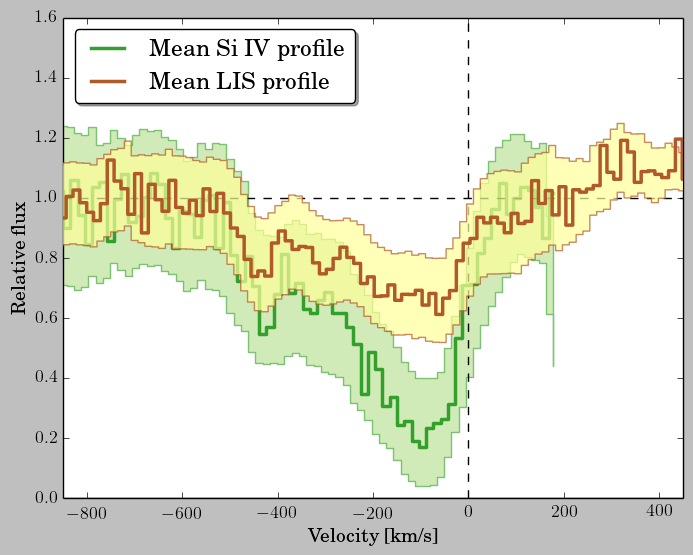

In [14]:
display(gcf())

In [7]:
fig, ax = plt.subplots(1)

ax.plot(vfhisTololo[1].Velocity, vfhisTololo[1].MeanProfile,
        label='Mean Si IV profile', drawstyle='steps-mid', 
        color=cosp.paircolors[3], lw=2.5, zorder=1)
# mp.fill_between_steps(hisvels, hismean+hiserrs, hismean-hiserrs, 
#                       color=cosp.paircolors[2], alpha=.6, 
#                       edgecolor=cosp.paircolors[3], zorder=0)

ax.plot(vflisTololo[1].Velocity, vflisTololo[1].MeanProfile, 
        label='Mean LIS profile', drawstyle='steps-mid', 
        color=cosp.paircolors[11], lw=2.5, zorder=4)
# mp.fill_between_steps(lisvels, lismean+liserrs, lismean-liserrs, 
#                       color=cosp.paircolors[10], alpha=.7, 
#                       edgecolor=cosp.paircolors[11], zorder=3)

ax.axhline(y=1., lw=1., color='k', ls='--')
ax.axhline(y=0., lw=1., color='k', ls='-')
ax.axvline(x=0., lw=1., color='k', ls='--')
ax.axis((-850, 450, 0., 1.6))
ax.legend(fancybox=True, shadow=True, loc='upper left')
ax.set_xlabel('Velocity [km/s]')
ax.set_ylabel('Relative flux')
plt.show()